# **Aggregated sensitivity analysis of single units: ResNet18**

## **Navigation**

- [**Basic imports and initialization**](#Basic-imports-and-initialization)
- [**1. Aggregated summary statistics**](#1.-Aggregated-summary-statistics)
- [**2. Aggregated sensitivity values**](#2.-Aggregated-sensitivity-values)

## Basic imports and initialization

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#Basic-imports-and-initialization)

- [Limiting the hardware resources, importing packages](#Limiting-the-hardware-resources,-importing-packages)
- [Initializing common variables](#Initializing-common-variables)


### Limiting the hardware resources, importing packages

$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Initializing-common-variables)

To provide easy access to modules stored in the ```../src/``` directory, we use the following workaround:

In [1]:
import sys
sys.path.append('../src/')

Next, we limit the hardware usage by setting the configuration dictionaries, maximum number of threads:

In [2]:
# set limitations on hardware
# fill on the template's config
import hardware_setup
hardware_setup.mkl_set_num_threads(num_threads=4)

[mkl]: set up num_threads=4/24


Then we import all necessary packages:

In [3]:
import os
import copy

import sensitivity_analysis.augmentation_setting
import sensitivity_analysis.visualize
import sensitivity_analysis.sua_visualize
import sensitivity_analysis.preprocess_visualize

import preparation.single_unit
import preparation.visualize

import exp_assistance

import matplotlib.pyplot as plt
%matplotlib inline

### Initializing common variables

[[$\leftarrow$Prev.subsect.]](#Limiting-the-hardware-resources,-importing-packages)$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$

In [4]:
data_dirname = '../data/imagenet'
activations_dirname = '../results/'
model_dirname = '../torch-models/'
exp_relative_path = '../experiments/'

network_name = 'resnet18'
values_fnm_base = 'imagenet_ILSVRC_values'

ncols_orig = 8
augmentation_set_numbers_list = [1, 2]

desired_image_height = 224
desired_image_width = 224

In [5]:
network_module_names = [
    'maxpool', # conv2d -> BN -> ReLU -> MaxPool2d
    'layer1', # Basic ResNet Block 1
    'layer2', # Basic ResNet Block 2
    'layer3', # Basic ResNet Block 3
    'avgpool', # Basic ResNet Block 1 -> AvgPool
    'fc'
]

n_conv_modules = 5

In [6]:
values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
)

n_neurons_dict = sensitivity_analysis.sua_visualize.get_number_of_neurons(
    values_fnms_dict['sitv'][1],
    activations_dirname,
    network_module_names,
    values_name='mean'
)


In [7]:
n_neurons_dict_to_article = {
    'layer3': (193, ),
}

## 1. Aggregated summary statistics

[[$\leftarrow$ Prev.part]](#Basic-imports-and-initialization) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#2.-Aggregated-sensitivity-values)


- [1.1 Initializing local variables](#1.1-Initializing-local-variables)
- [1.2 Log-transformed (modules of) mean values](#1.2-Log-transformed-(modules-of)-mean-values)
    - [1.2.1 Evaluating variables needed to plot the results](#1.2.1-Evaluating-variables-needed-to-plot-the-results)
    - [1.2.2 Plot the results (subset of neurons)](#1.2.2-Plot-the-results-(subset-of-neurons))
    - [1.2.3 Save the results](#1.2.3-Save-the-results)
- [1.3 Log-transformed total variances](#1.3-Log-transformed-total-variances)
    - [1.3.1 Evaluating variables needed to plot the results](#1.3.1-Evaluating-variables-needed-to-plot-the-results)
    - [1.3.2 Plot the results (subset of neurons)](#1.3.2-Plot-the-results-(subset-of-neurons))
    - [1.3.3 Save the results](#1.3.3-Save-the-results)
- [1.4 Log-transformed  Coefficients of Variance](#1.4-Log-transformed-Coefficients-of-Variance)
    - [1.4.1 Evaluating variables needed to plot the results](#1.4.1-Evaluating-variables-needed-to-plot-the-results)
    - [1.4.2 Plot the results (subset of neurons)](#1.4.2-Plot-the-results-(subset-of-neurons))
    - [1.4.3 Save the results](#1.4.3-Save-the-results)

### 1.1 Initializing local variables

$\quad$[[Back to section]](#1.-Aggregated-summary-statistics)$\quad$[[Next subsect.$\to$]](#1.2-Log-transformed-(modules-of)-mean-values)

In [8]:
values_funcs = {
    'sitv': {
        'mean': sensitivity_analysis.preprocess_visualize.log_scale,
        'var': sensitivity_analysis.preprocess_visualize.log_scale,
        ('var', 'mean'): sensitivity_analysis.preprocess_visualize.compute_coef_var,
    },
    'shptv': {
        'mean': sensitivity_analysis.preprocess_visualize.log_scale,
        'var': sensitivity_analysis.preprocess_visualize.log_scale,
        ('var', 'mean'): sensitivity_analysis.preprocess_visualize.compute_coef_var,
    }
}

plotter_func_kwargs_dict = {
    'values_fnms_dict': values_fnms_dict,
    'activations_dirname': activations_dirname,
    'augmentation_set_numbers_list': augmentation_set_numbers_list, # 
    'values_funcs': values_funcs,
    'ncols_orig': ncols_orig,
}

plot_colorbar = True
figsize = (20, 8)
figsize_save = (5, 4)
cmap = 'Reds'
colblocks_per_row = 4
N_neurons = 8
dataset_part = None
ind_neurons_dict = dict((key, N_neurons) for key in n_neurons_dict)

agg_stat_imsave_path = os.path.join(
    activations_dirname,
    network_name,
    'aggregated_summary_stats'
)

### 1.2 Log-transformed (modules of) mean values

[[$\leftarrow$Prev.subsect.]](#1.1-Initializing-local-variables)$\quad$[[Back to section]](#1.-Aggregated-summary-statistics)$\quad$[[Next subsect.$\to$]](#1.3-Log-transformed-total-variances)

- [1.2.1 Evaluating variables needed to plot the results](#1.2.1-Evaluating-variables-needed-to-plot-the-results)
- [1.2.2 Plot the results (subset of neurons)](#1.2.2-Plot-the-results-(subset-of-neurons))
- [1.2.3 Save the results](#1.2.3-Save-the-results)

#### 1.2.1 Evaluating variables needed to plot the results

[[Back to subsection]](#1.2-Log-transformed-(modules-of)-mean-values)

In [9]:
means_values_names_dict = {
    'sitv': ['mean'],
    'shptv': ['mean'],
}

means_vmin, means_vmax = sensitivity_analysis.sua_visualize.get_global_vmin_vmax(
    values_fnms_dict,
    activations_dirname,
    augmentation_set_numbers_list,
    network_module_names,
    means_values_names_dict,
    n_conv_modules,
    global_bounds_conv_only=True,
    values_funcs=values_funcs
)

#### 1.2.2 Plot the results (subset of neurons)

[[Back to subsection]](#1.2-Log-transformed-(modules-of)-mean-values)

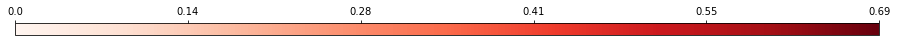


		 maxpool


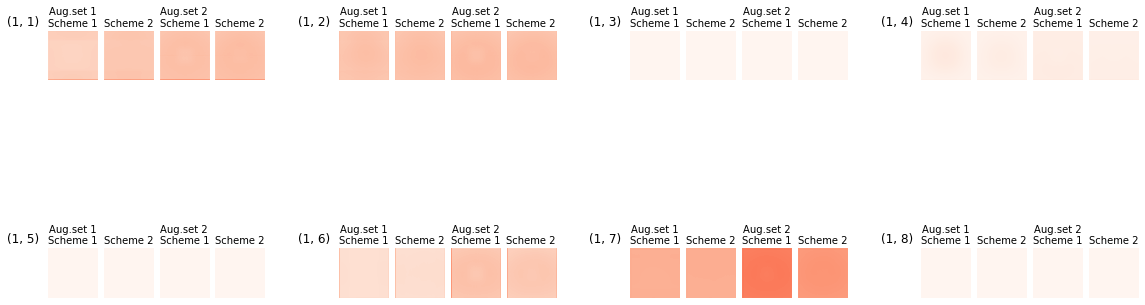


		 layer1


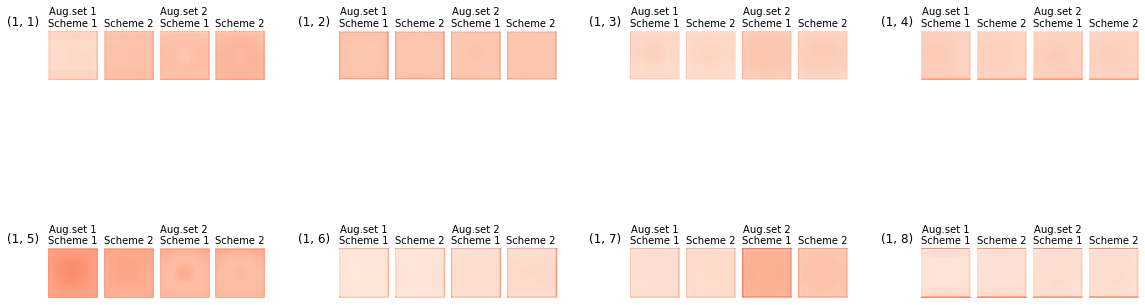


		 layer2


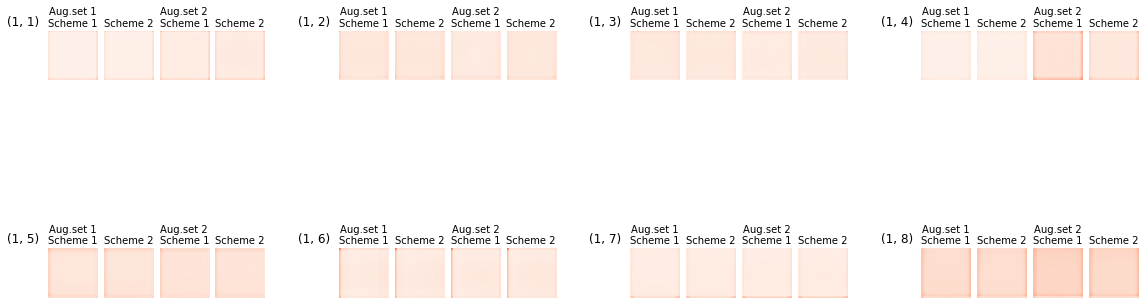


		 layer3


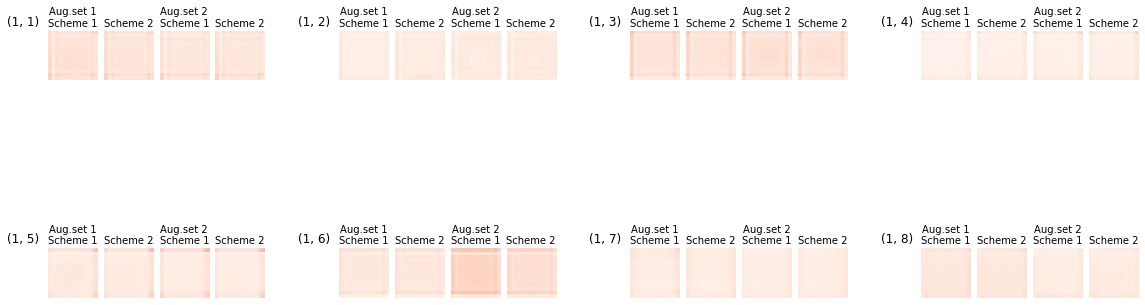


		 avgpool


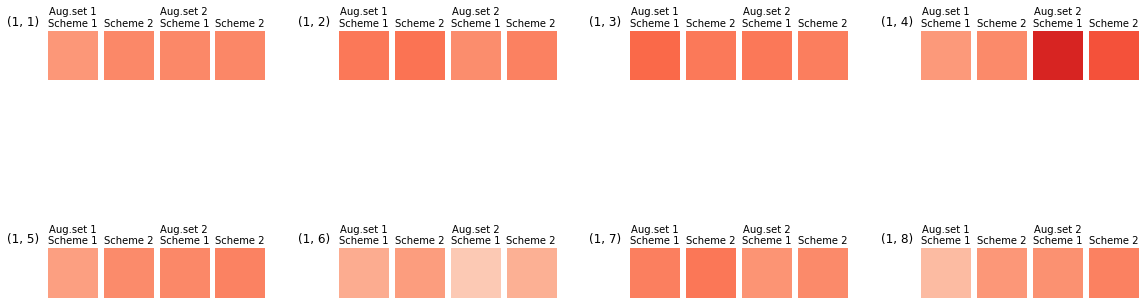

In [10]:
plotter_func_kwargs_dict['values_names_dict'] = means_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_plot(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    colblocks_per_row,
    ind_neurons_dict,
    vmin=0.,
    vmax=means_vmax,
    cmap=cmap,
    figsize=figsize,
    plot_colorbar=plot_colorbar,
)

#### 1.2.3 Save the results

[[Back to subsection]](#1.2-Log-transformed-(modules-of)-mean-values)

In [ ]:
plotter_func_kwargs_dict['values_names_dict'] = means_values_names_dict

sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    n_neurons_dict,
    save_path=os.path.join(agg_stat_imsave_path, 'means'),
    save_filename_base='Mean',
    vmin=0.,
    vmax=means_vmax,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
)

### 1.3 Log-transformed total variances

[[$\leftarrow$Prev.subsect.]](#1.2-Log-transformed-(modules-of)-mean-values)$\quad$[[Back to section]](#1.-Aggregated-summary-statistics)$\quad$[[Next subsect.$\to$]](#1.4-Log-transformed-Coefficients-of-Variance)

- [1.3.1 Evaluating variables needed to plot the results](#1.3.1-Evaluating-variables-needed-to-plot-the-results)
- [1.3.2 Plot the results (subset of neurons)](#1.3.2-Plot-the-results-(subset-of-neurons))
- [1.3.3 Save the results](#1.3.3-Save-the-results)

#### 1.3.1 Evaluating variables needed to plot the results

[[Back to subsection]](#1.3-Log-transformed-total-variances)

In [12]:
vars_values_names_dict = {
    'sitv': ['var'],
    'shptv': ['var'],
}

vars_vmin, vars_vmax = sensitivity_analysis.sua_visualize.get_global_vmin_vmax(
    values_fnms_dict,
    activations_dirname,
    augmentation_set_numbers_list,
    network_module_names,
    vars_values_names_dict,
    n_conv_modules,
    global_bounds_conv_only=True,
    values_funcs=values_funcs
)

#### 1.3.2 Plot the results (subset of neurons)

[[Back to subsection]](#1.3-Log-transformed-total-variances)

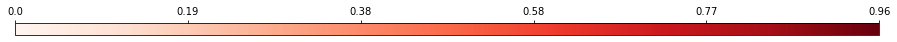


		 maxpool


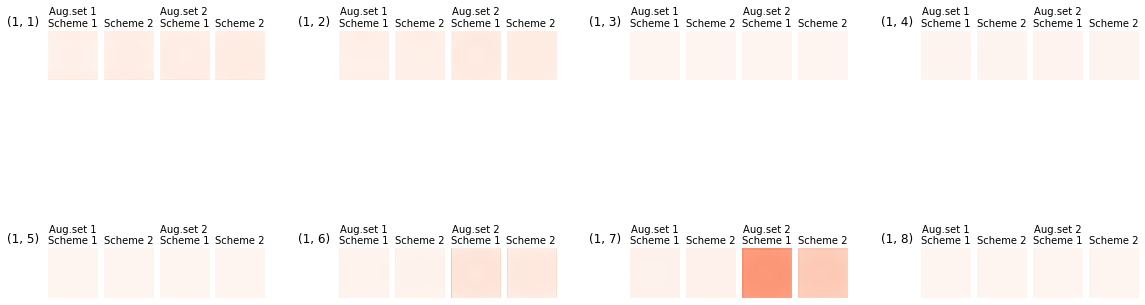


		 layer1


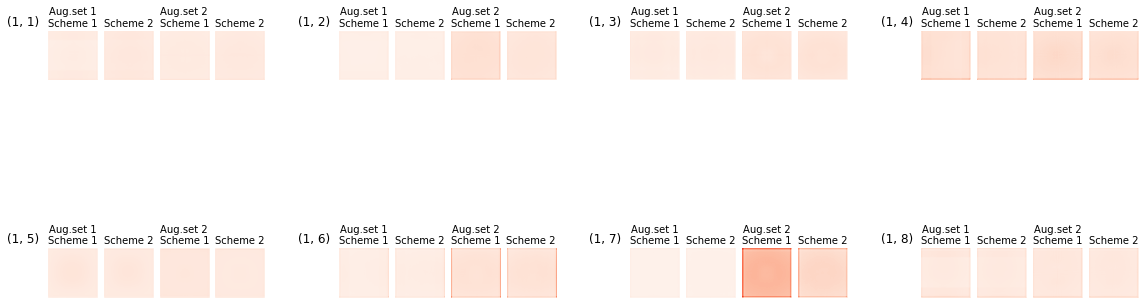


		 layer2


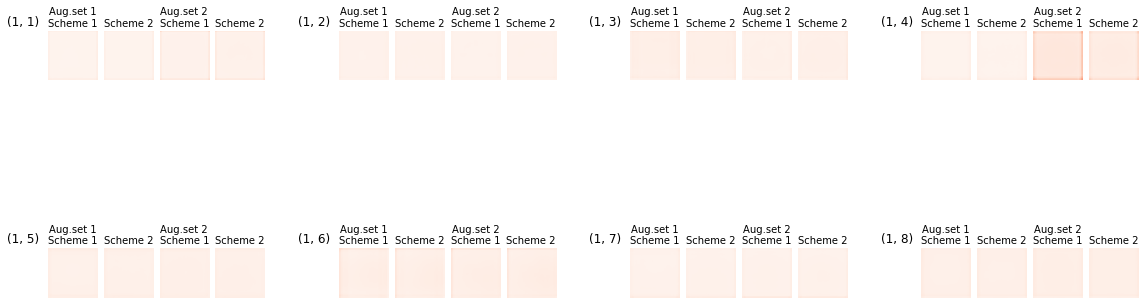


		 layer3


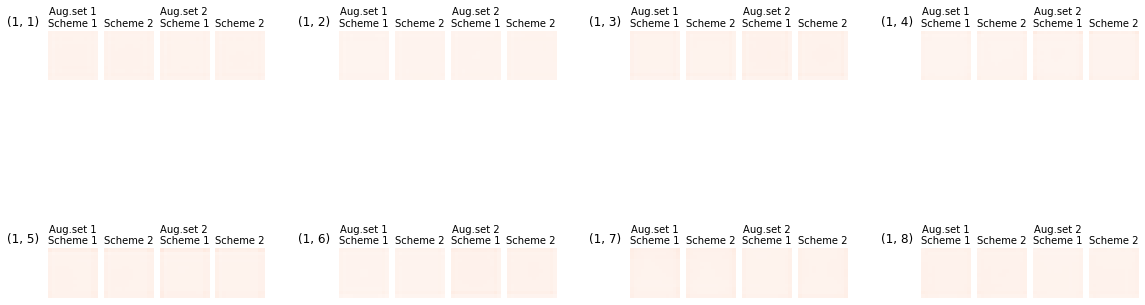


		 avgpool


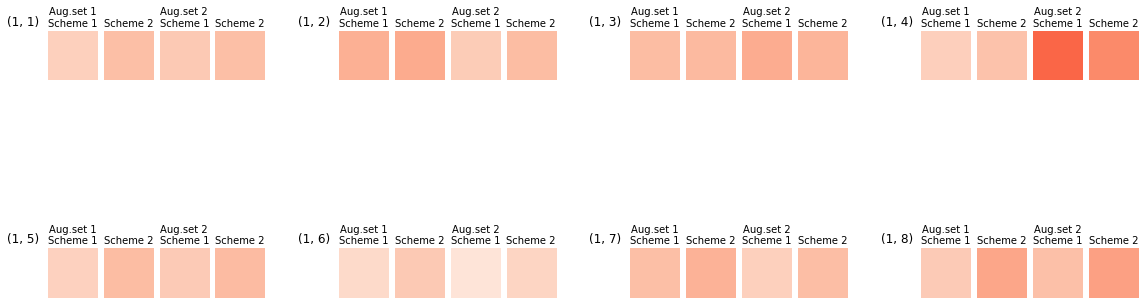

In [13]:
plotter_func_kwargs_dict['values_names_dict'] = vars_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_plot(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    colblocks_per_row,
    ind_neurons_dict,
    vmin=0.,
    vmax=vars_vmax,
    cmap=cmap,
    figsize=figsize,
    plot_colorbar=plot_colorbar,
)

#### 1.3.3 Save the results

[[Back to subsection]](#1.3-Log-transformed-total-variances)

In [ ]:
plotter_func_kwargs_dict['values_names_dict'] = vars_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    n_neurons_dict,
    save_path=os.path.join(agg_stat_imsave_path, 'vars'),
    save_filename_base='Var',
    vmin=0.,
    vmax=vars_vmax,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
)

### 1.4 Log-transformed Coefficients of Variance

[[$\leftarrow$Prev.subsect.]](#1.3-Log-transformed-total-variances)$\quad$[[Back to section]](#1.-Aggregated-summary-statistics)$\quad$


- [1.4.1 Evaluating variables needed to plot the results](#1.4.1-Evaluating-variables-needed-to-plot-the-results)
- [1.4.2 Plot the results (subset of neurons)](#1.4.2-Plot-the-results-(subset-of-neurons))
- [1.4.3 Save the results](#1.4.3-Save-the-results)

#### 1.4.1 Evaluating variables needed to plot the results

[[Back to subsection]](#1.4-Log-transformed-Coefficients-of-Variance)

In [15]:
covs_values_names_dict = {
    'sitv': [('var', 'mean')],
    'shptv': [('var', 'mean')],
}

cov_vmin, cov_vmax = sensitivity_analysis.sua_visualize.get_global_vmin_vmax(
    values_fnms_dict,
    activations_dirname,
    augmentation_set_numbers_list,
    network_module_names,
    covs_values_names_dict,
    n_conv_modules,
    global_bounds_conv_only=True,
    values_funcs=values_funcs
)

#### 1.4.2 Plot the results (subset of neurons)

[[Back to subsection]](#1.4-Log-transformed-Coefficients-of-Variance)

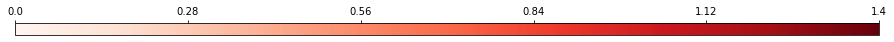


		 maxpool


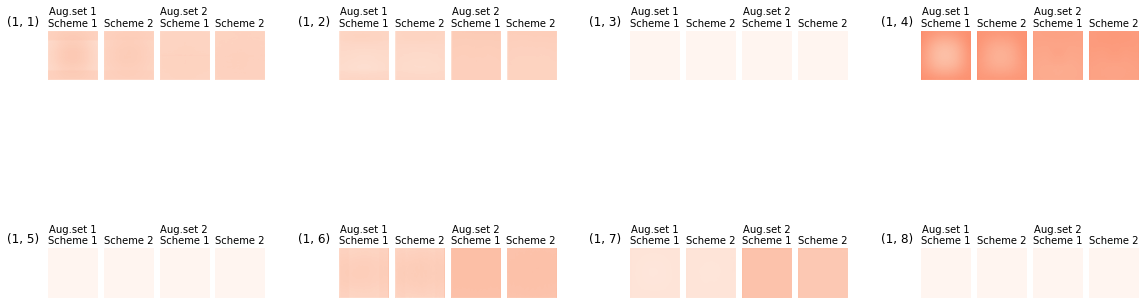


		 layer1


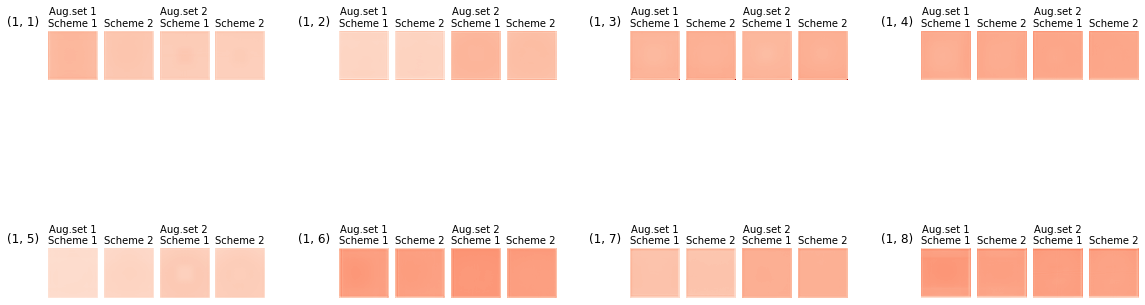


		 layer2


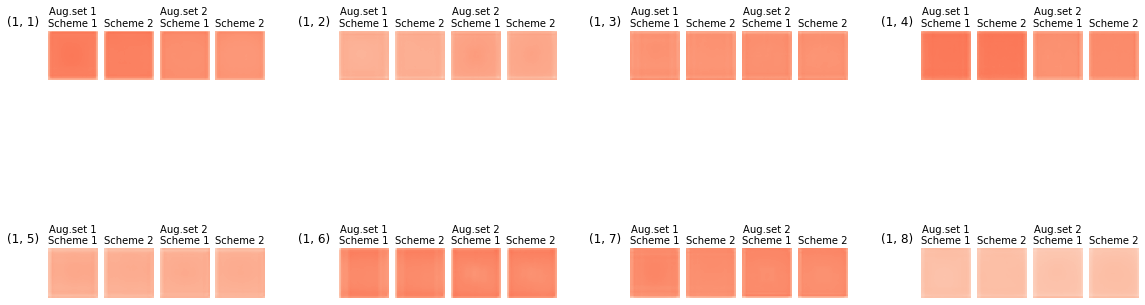


		 layer3


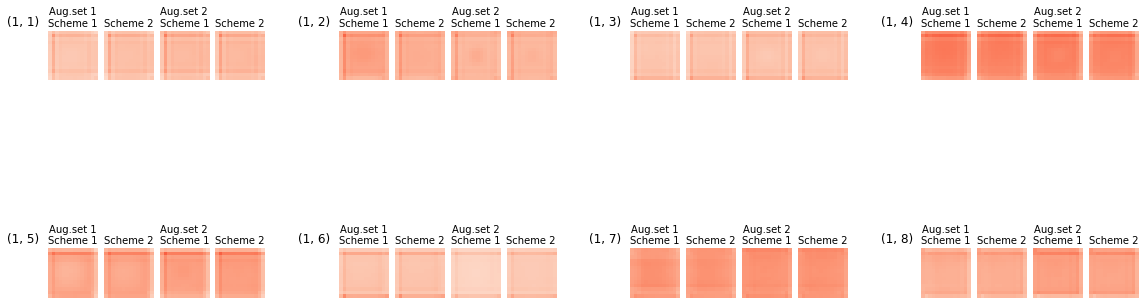


		 avgpool


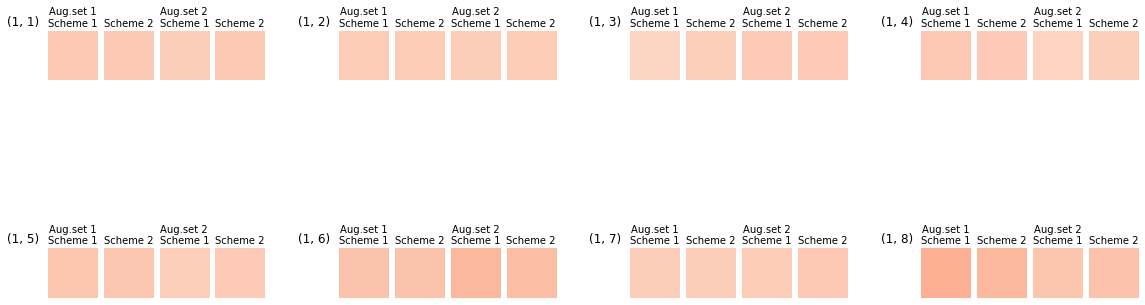

In [16]:
plotter_func_kwargs_dict['values_names_dict'] = covs_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_plot(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    colblocks_per_row,
    ind_neurons_dict,
    vmin=0.,
    vmax=cov_vmax,
    cmap=cmap,
    figsize=figsize,
    plot_colorbar=plot_colorbar,
)

#### 1.4.3 Save the results

[[Back to subsection]](#1.4-Log-transformed-Coefficients-of-Variance)

In [ ]:
plotter_func_kwargs_dict['values_names_dict'] = covs_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    n_neurons_dict,
    save_path=os.path.join(agg_stat_imsave_path, 'covs'),
    save_filename_base='CoV',
    vmin=0.,
    vmax=cov_vmax,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
)

In [ ]:
plotter_func_kwargs_dict['values_names_dict'] = covs_values_names_dict
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[3:4],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot,
    plotter_func_kwargs_dict,
    n_neurons_dict_to_article,
    save_path=os.path.join(agg_stat_imsave_path, 'covs'),
    save_filename_base='CoV',
    vmin=0.,
    vmax=1.5,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
    save_fmt='pdf',
)

## 2. Aggregated sensitivity values

[[$\leftarrow$ Prev.part]](#1.-Aggregated-summary-statistics) $\qquad$ [[Back to top]](#Navigation) $\qquad$

- [2.1 Comparing all the considered values](#2.1-Comparing-all-the-considered-values)
    - [2.1.1 Evaluating variables needed to plot the results](#2.1.1-Evaluating-variables-needed-to-plot-the-results)
    - [2.1.2 Plot the results (subset of neurons)](#2.1.2-Plot-the-results-(subset-of-neurons))
    - [2.1.3 Save the results](#2.1.3-Save-the-results)
- [2.2 Comparing sensitivity values](#2.2-Comparing-sensitivity-values)
    - [2.2.1 Evaluating variables needed to plot the results](#2.2.1-Evaluating-variables-needed-to-plot-the-results)
    - [2.2.2 Plot the results (subset of neurons)](#2.2.2-Plot-the-results-(subset-of-neurons))
    - [2.2.3 Save the results](#2.2.3-Save-the-results)

### 2.1 Comparing all the considered values

$\quad$[[Back to section]](#2.-Aggregated-sensitivity-values)$\quad$[[Next subsect.$\to$]](#2.2-Comparing-sensitivity-values)

- [2.1.1 Evaluating variables needed to plot the results](#2.1.1-Evaluating-variables-needed-to-plot-the-results)
- [2.1.2 Plot the results (subset of neurons)](#2.1.2-Plot-the-results-(subset-of-neurons))
- [2.1.3 Save the results](#2.1.3-Save-the-results)

#### 2.1.1 Evaluating variables needed to plot the results

[[Back to subsection]](#2.1-Comparing-all-the-considered-values)

In [19]:
row_names_list = [
    'rbscc (train)',
    'rbscc (valid)',
    'shpv',
    'si',
    'siT'
]
    
shpv_group_indices_dict = {}
for augmentation_set_number in augmentation_set_numbers_list:
    shpv_group_indices_dict[
        augmentation_set_number
    ] = sensitivity_analysis.augmentation_setting.get_group_variables_indices(
        augmentation_set_number,
        use_permutation_variable=True,
        use_class_variable=True,
        use_partition_variable=True
    )

plotter_func_kwargs_dict = {
    'values_fnms_dict': values_fnms_dict,
    'activations_dirname': activations_dirname,
    'augmentation_set_numbers_list': augmentation_set_numbers_list, # 
    'row_names_list': row_names_list,
    'ncols_orig': ncols_orig,
    'shpv_group_indices_dict': shpv_group_indices_dict
}
plot_colorbar = True
figsize = (22, 18)
figsize_save = (10, 4)
cmap = 'Reds'
colblocks_per_row = 2
N_neurons = 4
ind_neurons_dict = dict((key, N_neurons) for key in n_neurons_dict)

agg_sav_imsave_path = os.path.join(
    activations_dirname,
    network_name,
    'agg_sens_values_aug'
)

#### 2.1.2 Plot the results (subset of neurons)

[[Back to subsection]](#2.1-Comparing-all-the-considered-values)

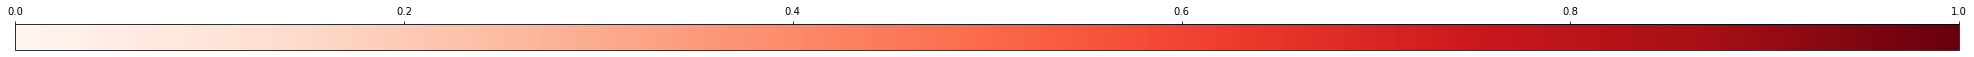


		 maxpool


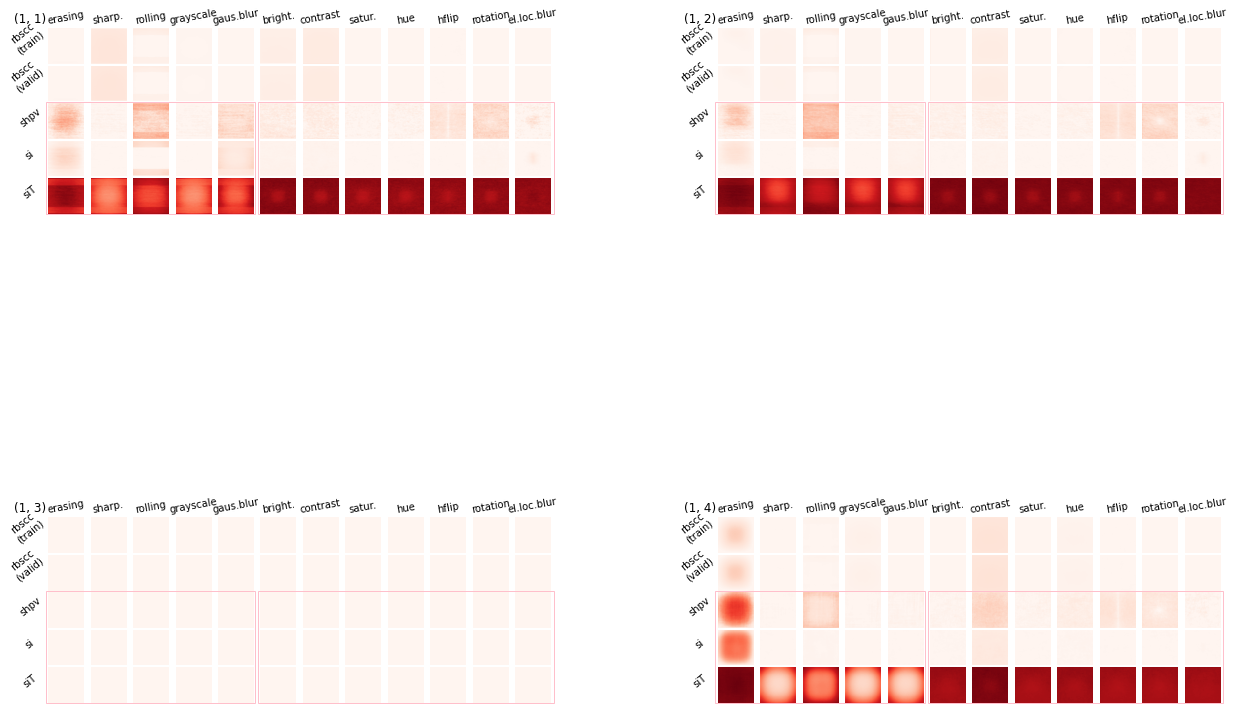


		 layer1


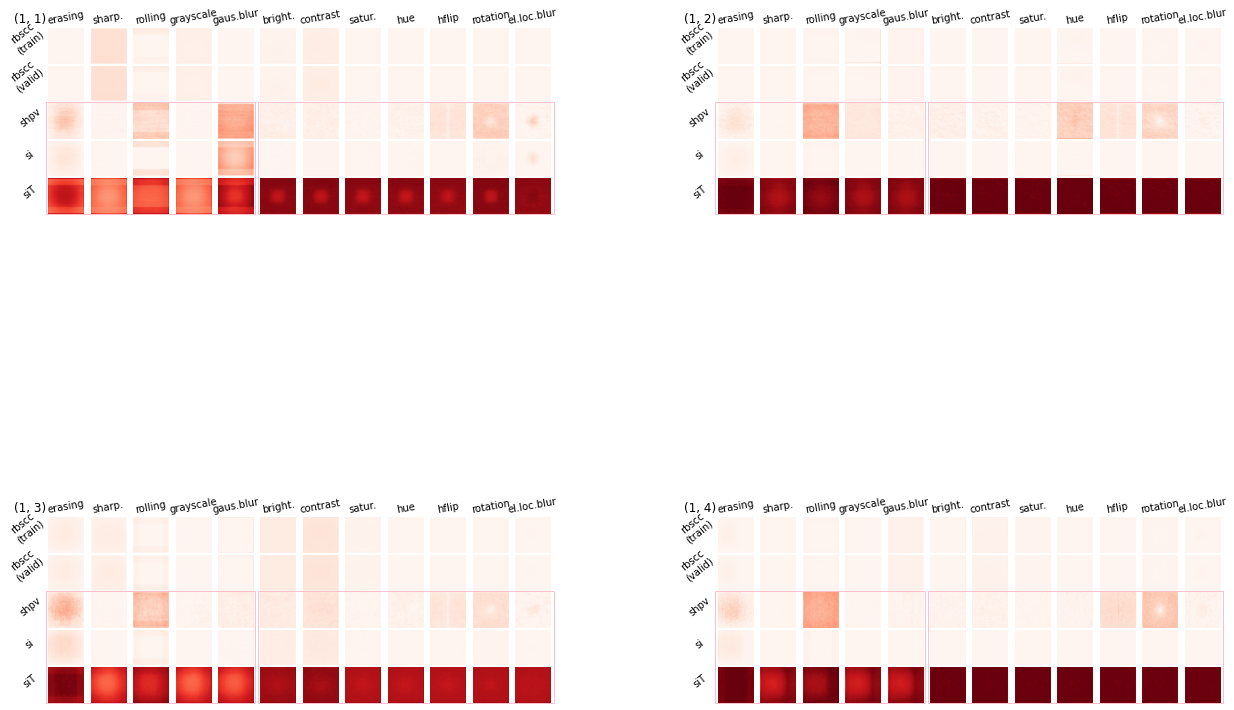


		 layer2


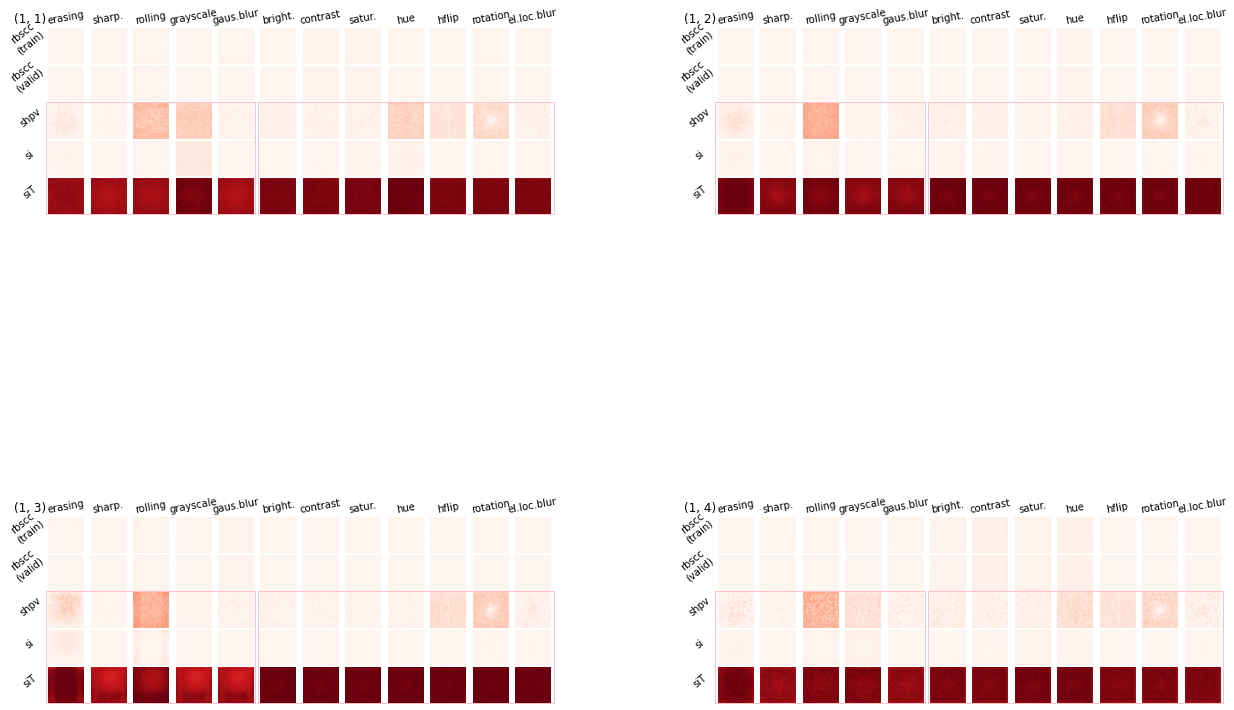


		 layer3


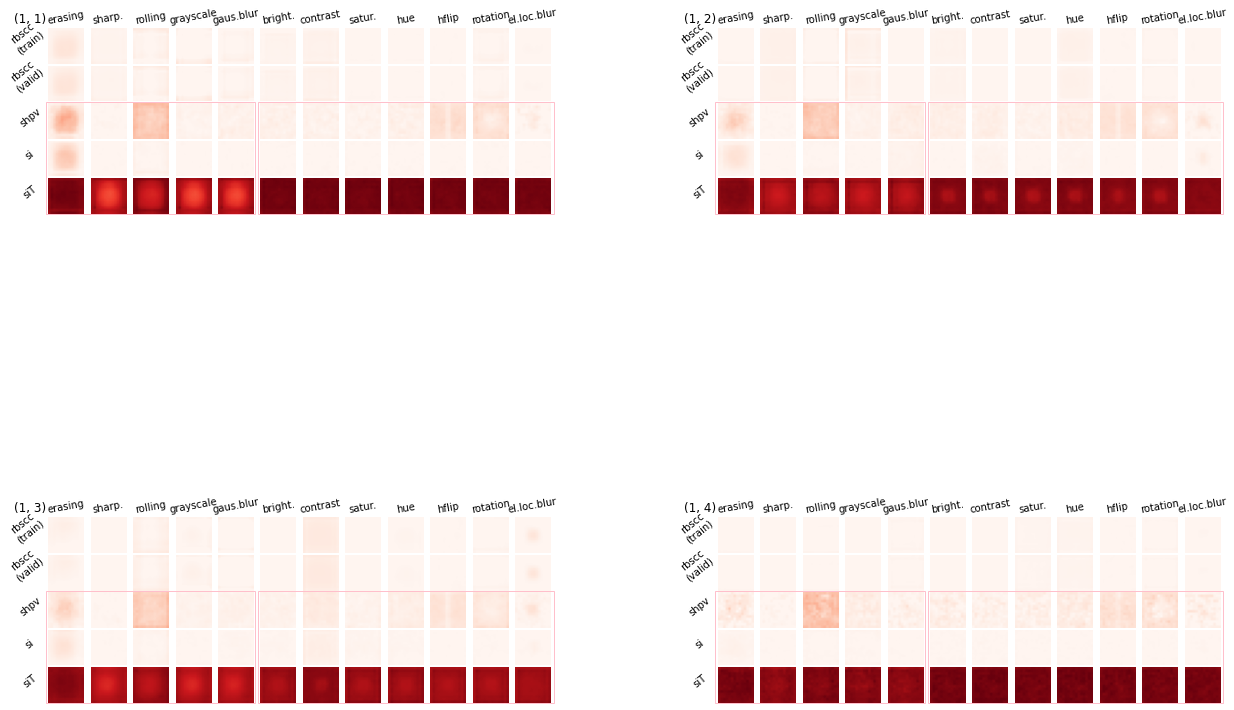


		 avgpool


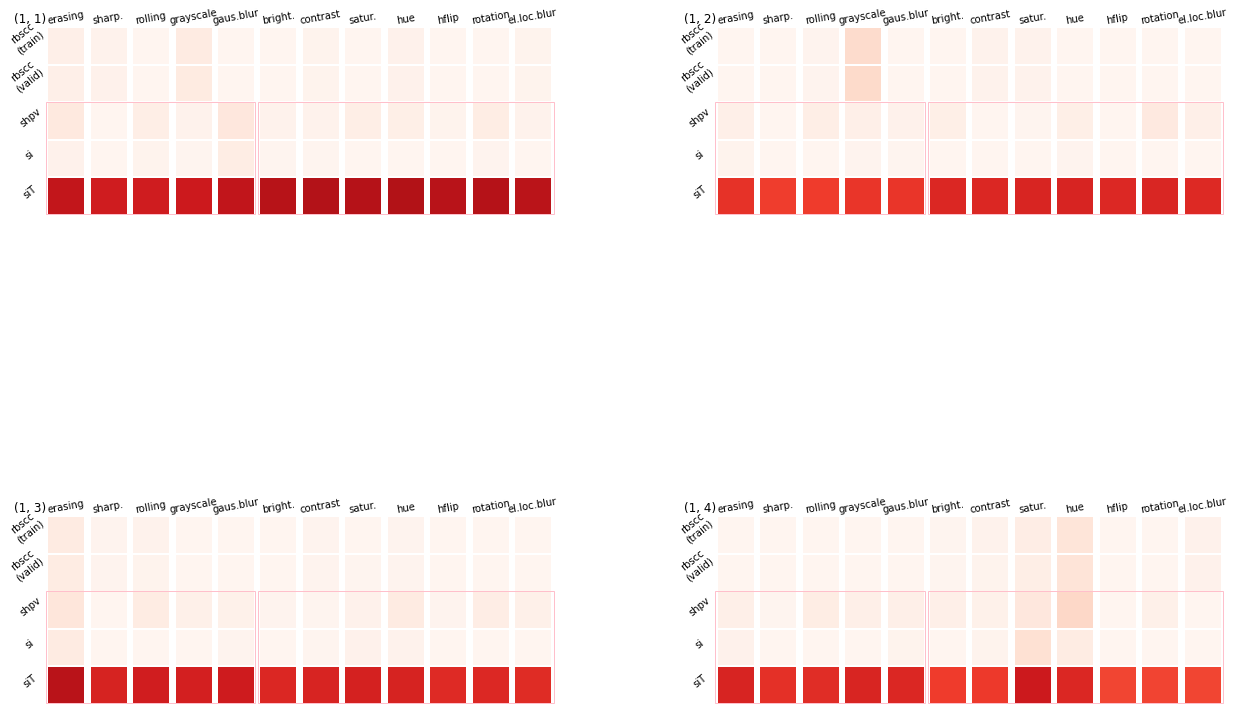

In [20]:
sensitivity_analysis.sua_visualize.multi_neuron_block_plot(
    network_module_names[:n_conv_modules],
    preparation.visualize.single_neuron_aug_plot,
    plotter_func_kwargs_dict,
    colblocks_per_row,
    ind_neurons_dict,
    vmin=0.,
    vmax=1,
    cmap=cmap,
    figsize=figsize,
    plot_colorbar=plot_colorbar,
)

#### 2.1.3 Save the results

[[Back to subsection]](#2.1-Comparing-all-the-considered-values)

In [ ]:
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[:n_conv_modules],
    preparation.visualize.single_neuron_aug_plot,
    plotter_func_kwargs_dict,
    n_neurons_dict,
    save_path=agg_sav_imsave_path,
    save_filename_base='agg_sens_vals_aug',
    vmin=0.,
    vmax=1.,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
)

### 2.2 Comparing sensitivity values

[[$\leftarrow$Prev.subsect.]](#2.1-Comparing-all-the-considered-values)$\quad$[[Back to section]](#2.-Aggregated-sensitivity-values)$\quad$
    
- [2.2.1 Evaluating variables needed to plot the results](#2.2.1-Evaluating-variables-needed-to-plot-the-results)
- [2.2.2 Plot the results (subset of neurons)](#2.2.2-Plot-the-results-(subset-of-neurons))
- [2.2.3 Save the results](#2.2.3-Save-the-results)

#### 2.2.1 Evaluating variables needed to plot the results

[[Back to subsection]](#2.2-Comparing-sensitivity-values)

In [22]:
agg_sens_values_names_dict = {
    'shpv': ['shpv'],
    'si': ['si', 'siT'],
}

shpv_group_indices_dict = {}
for augmentation_set_number in augmentation_set_numbers_list:
    shpv_group_indices_dict[
        augmentation_set_number
    ] = sensitivity_analysis.augmentation_setting.get_group_variables_indices(
        augmentation_set_number,
        use_permutation_variable=True,
        use_class_variable=True,
        use_partition_variable=True
    )

plotter_func_kwargs_dict = {
    'values_fnms_dict': values_fnms_dict,
    'activations_dirname': activations_dirname,
    'augmentation_set_numbers_list': augmentation_set_numbers_list, # 
    'values_names_dict': agg_sens_values_names_dict,
    'ncols_orig': ncols_orig,
    'shpv_group_indices_dict': shpv_group_indices_dict
}
plot_colorbar = True
figsize = (30, 25)
figsize_save = (14, 8)
cmap = 'Reds'
colblocks_per_row = 2
N_neurons = 4
ind_neurons_dict = dict((key, N_neurons) for key in n_neurons_dict)

agg_sav_imsave_path = os.path.join(
    activations_dirname,
    network_name,
    'agg_sens_values_aug_aux'
)

#### 2.2.2 Plot the results (subset of neurons)

[[Back to subsection]](#2.2-Comparing-sensitivity-values)

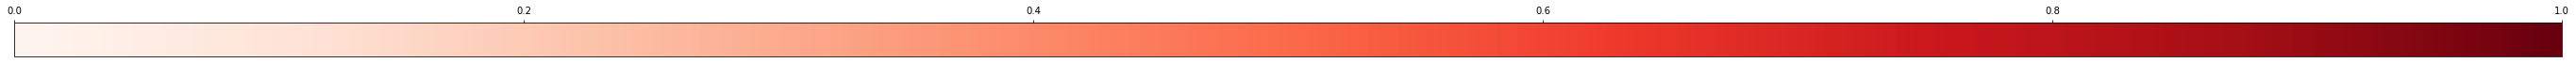


		 maxpool


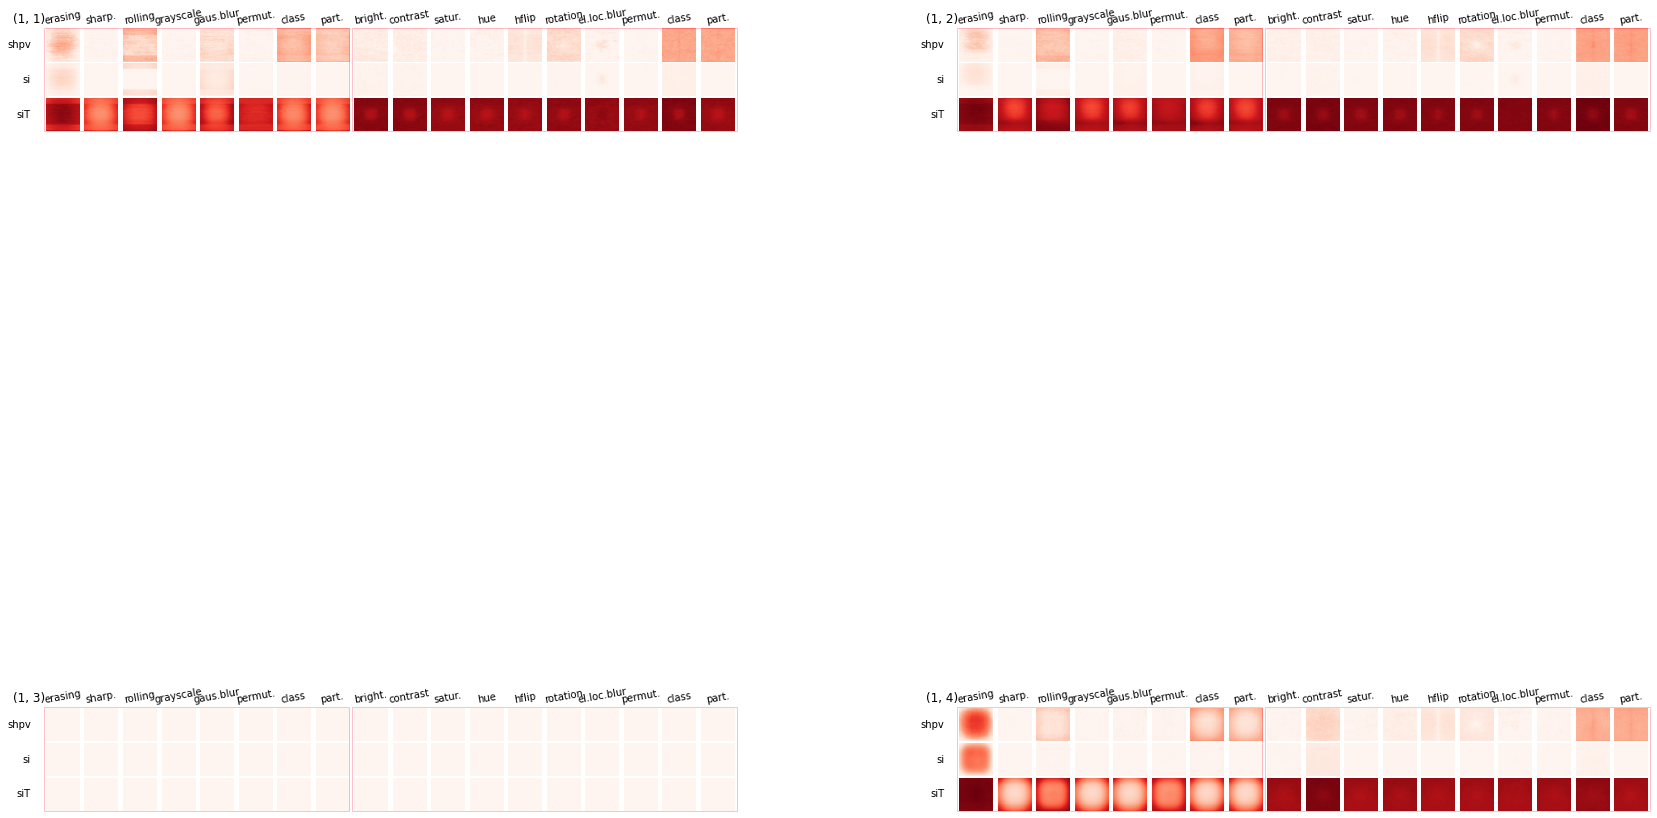


		 layer1


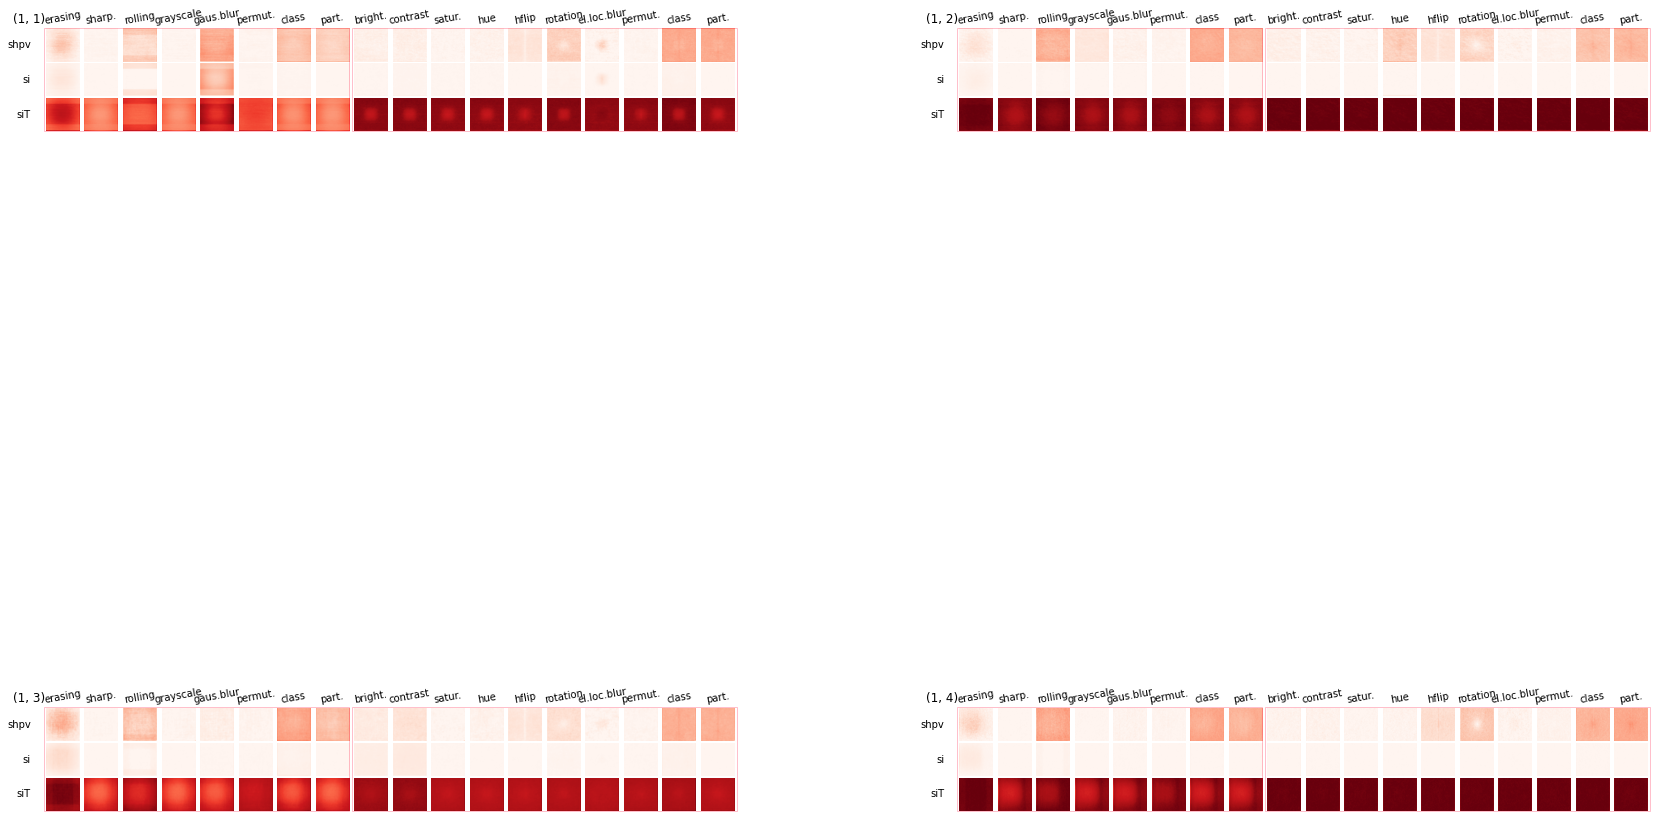


		 layer2


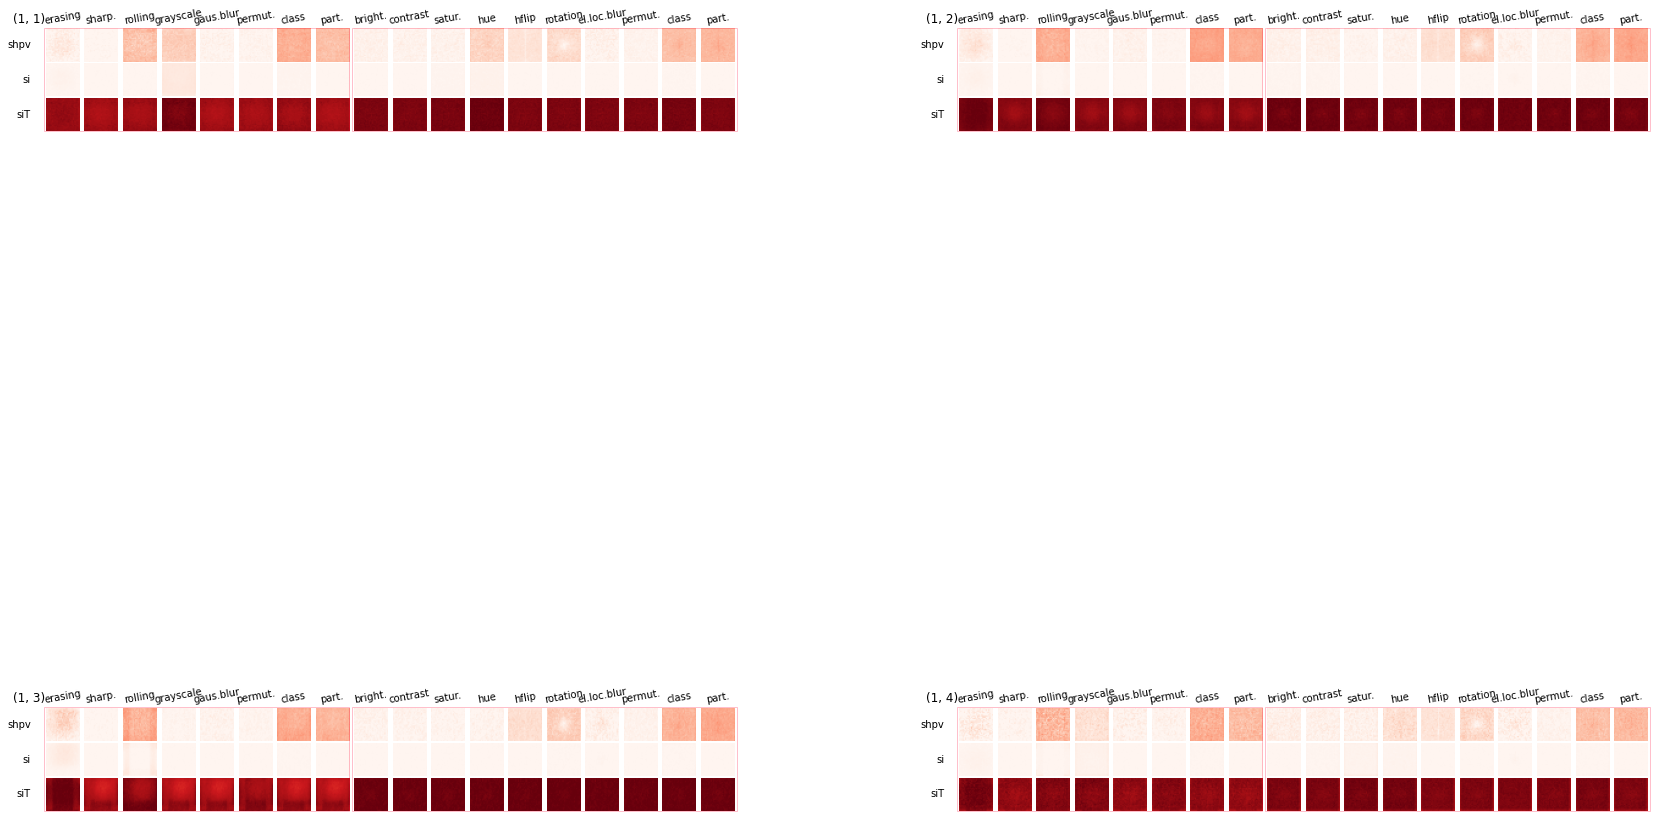


		 layer3


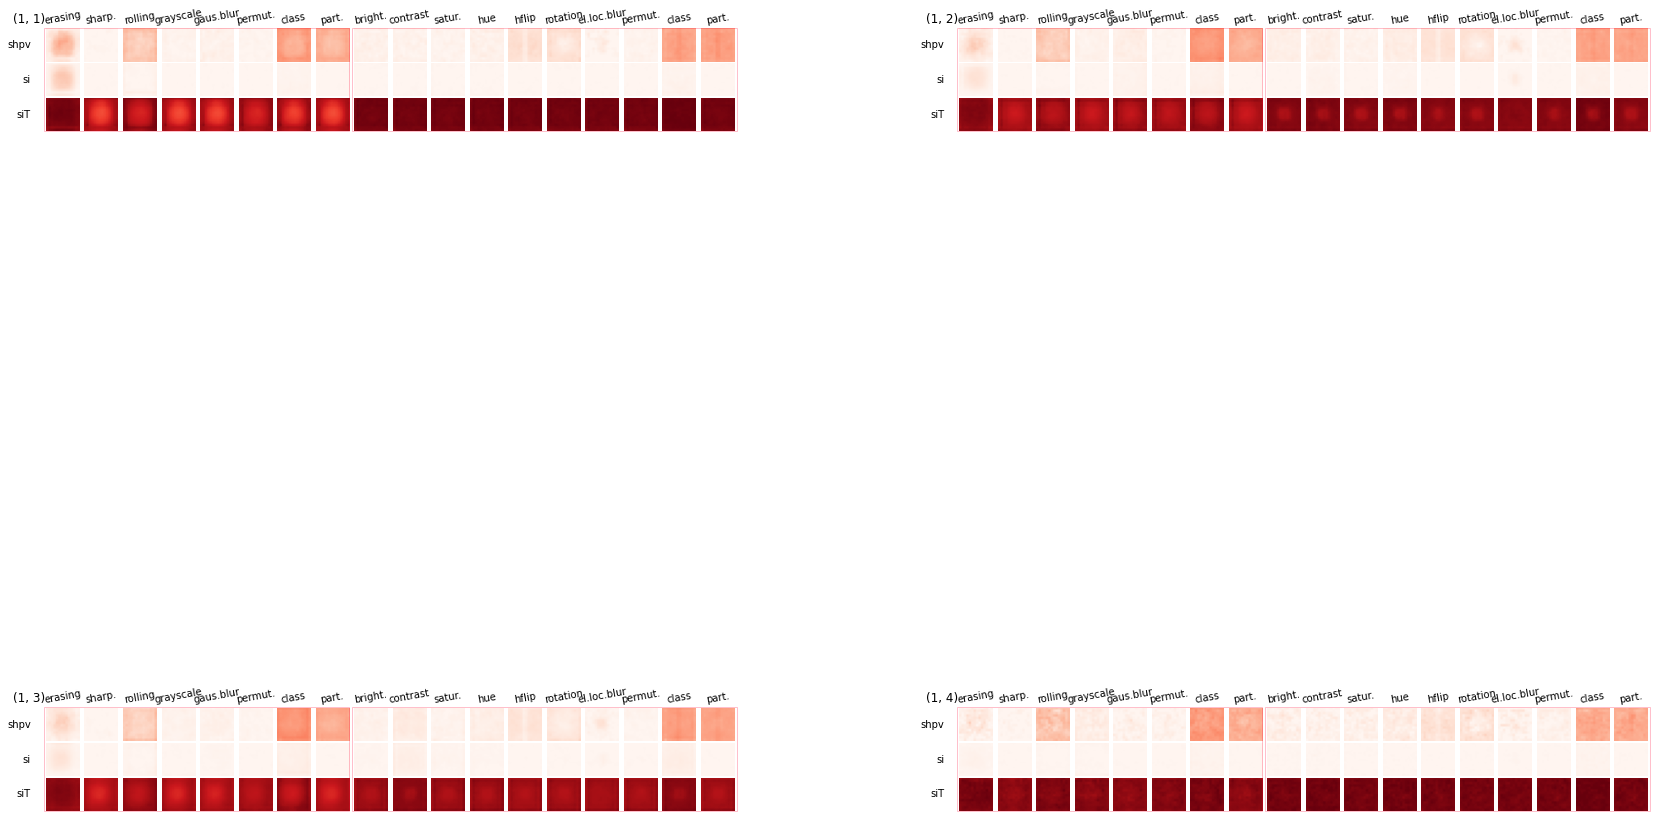


		 avgpool


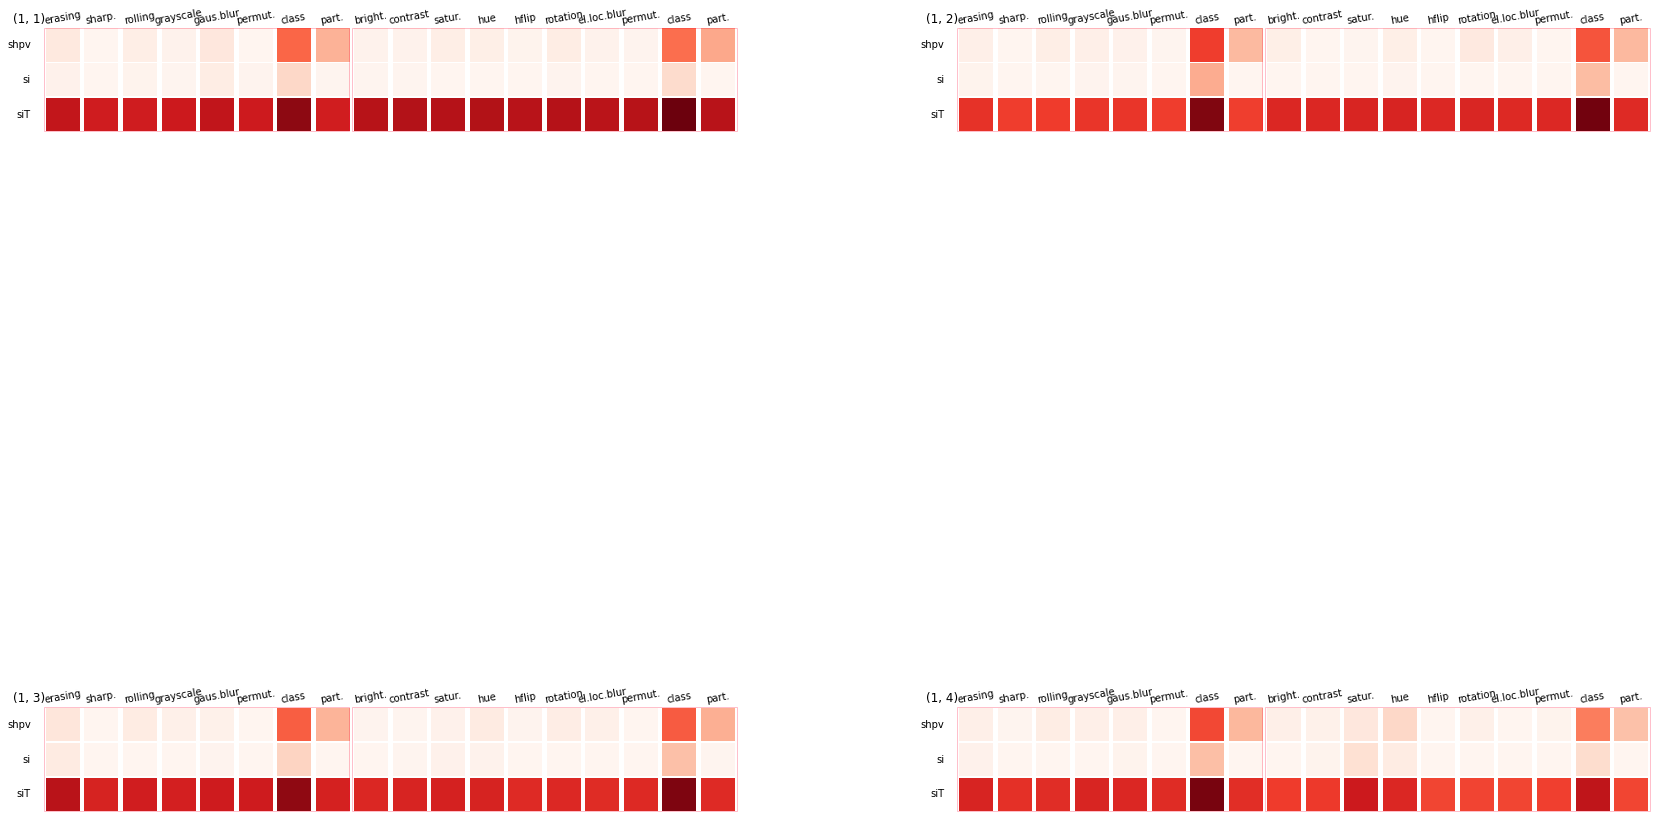

In [23]:
sensitivity_analysis.sua_visualize.multi_neuron_block_plot(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot_2,
    plotter_func_kwargs_dict,
    colblocks_per_row,
    ind_neurons_dict,
    vmin=0.,
    vmax=1,
    cmap=cmap,
    figsize=figsize,
    plot_colorbar=plot_colorbar,
)


#### 2.2.3 Save the results

[[Back to subsection]](#2.2-Comparing-sensitivity-values)

In [ ]:
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[:n_conv_modules],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot_2,
    plotter_func_kwargs_dict,
    n_neurons_dict,
    save_path=agg_sav_imsave_path,
    save_filename_base='agg_sens_vals_aug_aux',
    vmin=0.,
    vmax=1.,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
)

In [ ]:
sensitivity_analysis.sua_visualize.multi_neuron_block_save(
    network_module_names[3:4],
    sensitivity_analysis.sua_visualize.single_neuron_multiple_values_channeled_plot_2,
    plotter_func_kwargs_dict,
    n_neurons_dict_to_article,
    save_path=agg_sav_imsave_path,
    save_filename_base='agg_sens_vals_aug_aux',
    vmin=0.,
    vmax=1.,
    cmap=cmap,
    figsize=figsize_save,
    plot_colorbar=plot_colorbar,
    save_fmt='pdf',
)